# Twitter Sentiment Analysis

## 1 Problem description


This project consists of a classification problem, where we try to predict from tweet if it consists of hate speech or not.
The only data that we have access to are the tweets themselves, and the (binary) labels for the train set.

Source:
https://datahack.analyticsvidhya.com/contest/practice-problem-twitter-sentiment-analysis/


In [2]:
# importing modules

import pandas as pd
import numpy as np
import os
from collections import Counter
from unidecode import unidecode
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from tmp_module import * # custom module

%matplotlib

Using matplotlib backend: Qt5Agg


## 2. Data Extraction

In [3]:
df_train = pd.read_csv("train_E6oV3lV.csv", index_col=[0])
df_test = pd.read_csv("test_tweets_anuFYb8.csv", index_col=[0])

In [4]:
# to prepare data, we merge train and test data in a single dataframe:
df = pd.concat([df_train, df_test], sort=False)

A first step we should take a look at the data (or a small sample of) to see how it looks like, and see which kind of processing it needs.

In [5]:
pd.set_option('max_colwidth', 600) # this ensures that we extend the width of the dataframe columns to see its full conten
df.head()

,label,tweet
id,,
1,0.0,@user when a father is dysfunctional and is so selfish he drags his kids into his dysfunction. #run
2,0.0,@user @user thanks for #lyft credit i can't use cause they don't offer wheelchair vans in pdx. #disapointed #getthanked
3,0.0,bihday your majesty
4,0.0,#model i love u take with u all the time in urð±!!! ðððð ð¦ð¦ð¦
5,0.0,factsguide: society now #motivation


We observe that:

1. Some of the characters are not being correctly decoded, therefore we need to apply an extra step on data preparation to handle that.

2. The words after the @'s should correspond to user accounts, however, our sample seems to suggest that the different usernames were replaced simply by a '@user' tag. Nonetheless, we can count the occurrences of references to users in a tweet and use that as a new feature.

3. Apart from the references to other users, we can also distinguish between 'simple' text and text which is preceded by hashtags. So, we can separate those into two different features.

In [6]:
df['tweet'] = df["tweet"].map(unidecode)  # this corrects the strange characters we observe above

In [7]:
# counting the occurrences of the label '@user' in the tweet
df['user_refs'] = df['tweet'].str.findall("@user").str.len()

# removing the ocurrences of '@user' label in the twiit
# note: we create a new column for this, called 'text', to keep the original tweet as well
df['text'] = df['tweet'].str.replace("@user", "")  

In [8]:
# extracting the hashtags to a new column
df['hashtags'] = df['tweet'].str.findall('#\w+').map(lambda x: ' '.join(x))
df['text'] = df['text'].str.replace('#\w+', '')

In [9]:
# we apply an extra step to 'text' columns, to santize the strings
df['text'] = df['text'].map(lambda x: x.lower()).str.replace("\W+", " ")

In [10]:
# showing prepared data:
df.head()

,label,tweet,user_refs,text,hashtags
id,,,,,
1,0.0,@user when a father is dysfunctional and is so selfish he drags his kids into his dysfunction. #run,1,when a father is dysfunctional and is so selfish he drags his kids into his dysfunction,#run
2,0.0,@user @user thanks for #lyft credit i can't use cause they don't offer wheelchair vans in pdx. #disapointed #getthanked,2,thanks for credit i can t use cause they don t offer wheelchair vans in pdx,#lyft #disapointed #getthanked
3,0.0,bihday your majesty,0,bihday your majesty,
4,0.0,#model i love u take with u all the time in urd+-!!! ddddd|d|d|,0,i love u take with u all the time in urd ddddd d d,#model
5,0.0,factsguide: society now #motivation,0,factsguide society now,#motivation


## 2. Exploratory Data Analysis

As we did above, we should take a look at data, but now spliting it for the two types of labels (hate and 'non hate' tweets)

In [11]:
# size of train and test data
print('train set size:', len(df_train))
print('test set size:', len(df_test))

train set size: 31962
test set size: 17197


In [12]:
df_train.groupby('label')['tweet'].count() / df_train['tweet'].count()

label
0    0.929854
1    0.070146
Name: tweet, dtype: float64

=> 7% of the tweets have hate speech

### 2.1 How does the hate speech looks like?

In [13]:
df[df["label"] == 1].head(10)

,label,tweet,user_refs,text,hashtags
id,,,,,
14,1.0,@user #cnn calls #michigan middle school 'build the wall' chant '' #tcot,1,calls middle school build the wall chant,#cnn #michigan #tcot
15,1.0,no comment! in #australia #opkillingbay #seashepherd #helpcovedolphins #thecove #helpcovedolphins,0,no comment in,#australia #opkillingbay #seashepherd #helpcovedolphins #thecove #helpcovedolphins
18,1.0,retweet if you agree!,0,retweet if you agree,
24,1.0,@user @user lumpy says i am a . prove it lumpy.,2,lumpy says i am a prove it lumpy,
35,1.0,it's unbelievable that in the 21st century we'd need something like this. again. #neverump #xenophobia,0,it s unbelievable that in the 21st century we d need something like this again,#neverump #xenophobia
57,1.0,@user lets fight against #love #peace,1,lets fight against,#love #peace
69,1.0,d(c)the white establishment can't have blk folx running around loving themselves and promoting our greatness,0,d c the white establishment can t have blk folx running around loving themselves and promoting our greatness,
78,1.0,"@user hey, white people: you can call people 'white' by @user #race #identity #meda|",2,hey white people you can call people white by,#race #identity #meda
83,1.0,how the #altright uses &amp; insecurity to lure men into #whitesupremacy,0,how the uses amp insecurity to lure men into,#altright #whitesupremacy


Examples of 'Non hate' speech

In [14]:
df[df["label"] == 0].head(10)

,label,tweet,user_refs,text,hashtags
id,,,,,
1,0.0,@user when a father is dysfunctional and is so selfish he drags his kids into his dysfunction. #run,1,when a father is dysfunctional and is so selfish he drags his kids into his dysfunction,#run
2,0.0,@user @user thanks for #lyft credit i can't use cause they don't offer wheelchair vans in pdx. #disapointed #getthanked,2,thanks for credit i can t use cause they don t offer wheelchair vans in pdx,#lyft #disapointed #getthanked
3,0.0,bihday your majesty,0,bihday your majesty,
4,0.0,#model i love u take with u all the time in urd+-!!! ddddd|d|d|,0,i love u take with u all the time in urd ddddd d d,#model
5,0.0,factsguide: society now #motivation,0,factsguide society now,#motivation
6,0.0,[2/2] huge fan fare and big talking before they leave. chaos and pay disputes when they get there. #allshowandnogo,0,2 2 huge fan fare and big talking before they leave chaos and pay disputes when they get there,#allshowandnogo
7,0.0,@user camping tomorrow @user @user @user @user @user @user @user dannya|,8,camping tomorrow dannya,
8,0.0,the next school year is the year for exams.d- can't think about that d #school #exams #hate #imagine #actorslife #revolutionschool #girl,0,the next school year is the year for exams d can t think about that d,#school #exams #hate #imagine #actorslife #revolutionschool #girl
9,0.0,we won!!! love the land!!! #allin #cavs #champions #cleveland #clevelandcavaliers a|,0,we won love the land a,#allin #cavs #champions #cleveland #clevelandcavaliers


### 2.2 Most frequent Hashtags

In [15]:
# we create a counter of hashtags - only for train data
htPerTweet = df['hashtags'].map(lambda s: Counter(s.split()))
htCount_0 = htPerTweet[df['label'] == 0].sum()
htCount_1 = htPerTweet[df['label'] == 1].sum()
htCount = htCount_0 + htCount_1

In [16]:
table = pd.DataFrame({'tot': htCount, 0: htCount_0, 1: htCount_1}).fillna(0)

In [17]:
# most frequency hash tags - both hate and non hte speech
table.sort_values(by='tot', ascending=False).head()

,tot,0,1
#love,1542,1531.0,11.0
#positive,874,874.0,0.0
#healthy,571,570.0,1.0
#smile,548,548.0,0.0
#thankful,491,491.0,0.0


In [18]:
# most frequenct hashtags for hatespeech
table.sort_values(by=1, ascending=False).head()

,tot,0,1
#trump,176,43.0,133.0
#politics,99,5.0,94.0
#allahsoil,92,0.0,92.0
#libtard,77,1.0,76.0
#liberal,78,3.0,75.0


## 3. Prediction

### 3.1 Poisson Naive Bayes Model

The Poisson Bayes Model is an attempt to model label data $y$ with a probability distribution $P(y\mid X)$, where $X$ are the features.


1. **The 'Bayes' part:** In some cases it is more natural to model $P(X|y)$ instead of $P(y\mid X)$. The bayes law relates these two conditional probabilities through $P\left(y\mid X\right)=P\left(X\mid y\right)\cdot\frac{P(y)}{P(X)}$. Furthermore, assuming that the set of possible labels is discrete (in this case y is 0 or 1), we can write $P\left(y_k\mid X\right) =P\left( X\mid y\right) \cdot\frac{P\left( y_k\right)}{Z}$, where $Z = \sum_k P(y_k)\cdot P\left( X\mid y_k \right)$. (in the continuous case we can use an integral instead of a sum).


2. **The 'Naive' part** comes from the assumption that the different features $X=\left(x_1, \cdots,x_n\right)$ are independent conditional to each label, i.e, it is assumed that $P\left(X\mid y_k\right) =P\left( x_1\mid y_k\right)\cdots P\left( x_n\mid y_k\right)\forall k$.


3. **The 'Poisson' part** comes from the probability family distribution we choose to model each $P\left(x_i\mid y_k\right)$. In this case, because we are dealing with count data we choose a poisson distribution $Poi(\lambda_{ik})$, which depends only on one parameter $\lambda$, which is equal to its expectation.

### 3.1.1 Trainning

In a training stage, we need to determine the $\lambda_{ik}$ parameters, using training data.

1. If our prior assumption for this parameter is uniform then we only need to use the frequencies from the training set.
   Hence, for a given word $x_i$ and a given class $y_k$ our estimation should be
   $$\lambda_{ik} = \frac{\#\{tweet\mid tweet\in S_k, x_i\in tweet\} }{\#S_k}$$
   Where $S_k$ are the set of tweets with label $k$
   
&rarr; Having a uniform prior can lead to issues when applying the model to new tweets with new words, because $p\left(x\mid \lambda=0\right)=0 \forall x>0$ )

We should then have a prior assumption which is equivalent to observe $n$ tweets with an observation rate $\theta_k$.
2. Under the informal description, we did above we know that the conjugate prior for the poisson distribution is a gamma distribution $\Gamma$ with parameters $\alpha_{prior}=n\cdot\theta_k$ and $\beta_{prior}=n$.

Our posterior distribution, after observation of the train data will then have parameters  $\alpha_{posterior}=n\cdot\theta_k+\#\{tweet\mid tweet\in S_k, x_i\in tweet\}$ and $\beta_{posterior}=n + \#S_k$.

Therefore our estimation for $\lambda$ will be:
$$\lambda_{ik} = \frac{\#\{tweet\mid tweet\in S_k, x_i\in tweet\} + n\cdot\theta_k }{\#S_k + n}$$

$$\theta_k=\frac{\#\{(x, t)\in S_k\times L\mid x\in t\}}{\#S_k \#L}$$
Where $L$ is the vocabulary of words appearing in the train set.

### 3.1.2 Prediction

After calibrating the model, we need to do a prediction for validation or test data.
As described previously we will relly on $P\left(y_k\mid X\right) =\frac{P\left( y_k\right)}{Z} \cdot \prod_i P\left( x_i\mid y_k\right)$

For the poisson case we will have $$P\left(y_k\mid X\right) = \frac{P\left( y_k\right)}{Z}\cdot \exp{\left(\sum_i \left(x_i\cdot \log\lambda_{ik} - \lambda_{ik}\right)\right)} $$

Where $Z$ is a new normalization constant to handle the factors ($x_i!$) in the poisson distribution.

After this digression over the theory we can finally implement a proper model under the Scikit-learn API interface:

### 3.1.3 Algorithm evaluation

The performance evaluation of a predictive algorithm needs to be performed in a dataset which wasn't used for trainning.
Therefore we do 3-fold cross validation: we split the training set in 3 parts. We train the model using two parts and measure its score using the remaining part (validation). We can do this three times by chaging the block that we are using to validate the model.

In [19]:
# we use 'text' and 'hashtags' as feature
X = (df['text'] + " " + df["hashtags"]).str.strip().str.replace("\s+", " ").str.split(" ").map(Counter)
y = df['label']
X_train = X[y.notnull()]
y_train = y[y.notnull()]
X_test = X[y.isnull()]

In [20]:
clf = PoissonNaiveBayes()

In [21]:
f1scores = cross_val_score(clf, X_train.values, y_train.values, scoring="f1", cv=3, n_jobs=4)

In [22]:
f1scores.mean()

0.2154438513120447

We fit now the model to the whole dataset to make our final submission:

In [23]:
clf.fit(X_train, y_train)

PoissonNaiveBayes(n=1)

In [24]:
# prediction to submit
y_pred = pd.Series(clf.predict(X_test), index=X_test.index)
y_pred.to_frame("label").to_csv("naive_n1_submission.csv")

### 3.1.4 Hyperparameter Tuning

The regularization parameter $n$ we used above was set to 1, however, we can make our predictions using other values and evaluate the performances, using cross validation.

[Parallel(n_jobs=8)]: Done   3 out of  30 | elapsed: 11.6min remaining: 104.7min
[Parallel(n_jobs=8)]: Done   7 out of  30 | elapsed: 12.3min remaining: 40.4min
[Parallel(n_jobs=8)]: Done  11 out of  30 | elapsed: 24.0min remaining: 41.5min
[Parallel(n_jobs=8)]: Done  15 out of  30 | elapsed: 25.0min remaining: 25.0min
[Parallel(n_jobs=8)]: Done  19 out of  30 | elapsed: 36.5min remaining: 21.1min
[Parallel(n_jobs=8)]: Done  23 out of  30 | elapsed: 37.8min remaining: 11.5min
[Parallel(n_jobs=8)]: Done  27 out of  30 | elapsed: 45.8min remaining:  5.1min
[Parallel(n_jobs=8)]: Done  30 out of  30 | elapsed: 46.3min finished


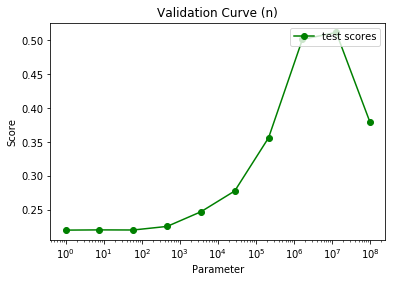

In [25]:
validation_curve(clf, X_train, y_train, 'f1', 'n', 0, 8, n_points=10, log_scale=True, train_curve=False, cv=3, n_jobs=8)

We choose $n=10^6$ as hyperparameter

In [25]:
clf = custom_module.PoissonNaiveBayes(n=1e6)

NameError: name 'custom_module' is not defined

In [ ]:
f1scores = cross_val_score(clf, X_train.values, y_train.values, scoring="f1", cv=3, n_jobs=4)

In [ ]:
f1scores.mean()

In [ ]:
clf.fit(X_test)

In [ ]:
# prediction to submit
y_pred = pd.Series(clf.predict(X_test), index=X_test.index)
y_pred.to_frame("label").to_csv("naive_n10_6_submission.csv")

## 3.2 Logistic Regression

Other model that we can use is a Logistic Regression. $y=s\left(A\cdot X\right)$ 

In [ ]:
lr = make_pipeline(TfidfVectorizer(), LogisticRegression())

In [ ]:
X = (df['text'] + " " + df["hashtags"]).str.strip().str.replace("\s+", " ")
y = df['label']
X_train = X[y.notnull()]
y_train = y[y.notnull()]
X_test = X[y.isnull()]

In [ ]:
f1scores = cross_val_score(lr, X_train.values, y_train.values, scoring="f1", cv=3, n_jobs=4)

In [ ]:
f1scores

In [ ]:
f1scores.mean()

In [ ]:
validation_curve(lr, X_train, y_train, 'f1', 'logisticregression__C', 0, 6, n_points=10, log_scale=True, train_curve=False, cv=3, n_jobs=8)

In [82]:
lr = make_pipeline(TfidfVectorizer(), LogisticRegression(C=1e2))

In [ ]:
lr.fit(X_test)

In [ ]:
# prediction to submit
y_pred = pd.Series(clf.predict(X_test), index=X_test.index)
y_pred.to_frame("label").to_csv("naive_n10_6_submission.csv")

## 4. Learning Curve

The learning curve shows how well an algorithm perform as function of the size of the training set.

If a model is too complex for a given training dataset - there are too many degrees of freedom or parameters in this model - the model tens to overfit the training data and does not generalize well to unseen data.

By plotting the model training and validation accuracies as functions of the training set size, we can easily detect wheder the model suggers from high variance (overfitting) or high bias (undefitting).

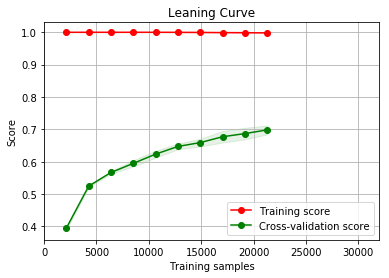

In [88]:
learning_curve(lr, X_train, y_train, scoring='f1', n_min=.1, n_max=1, n_points=10, log_scale=False, traincv=3, n_jobs=4)

We can observe that the model performs almost perfectly in the training set, however, te score in the test set is much lower.
Nonetheless, we also observe that the model benefits a lot with the incrise of the size of the training set. This suggests that, to 

## 5. Conclusions, recomendations and Next Steps

In this project we used only one of the most basic machine learning algorithms: the naive bayes classifier.

This algo has several advantages comparing with others. Due to it's 'naive' assumption, we actually

Other models:
 * linear regression
 * word2vec